In [1]:
%matplotlib notebook

import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
from sklearn.cluster import KMeans
import multiprocessing
from functools import partial
import time

import wolff
import wolff_cross

# Track calculation errors
np.seterr('raise')

tf.debugging.set_log_device_placement(True)
tf.config.experimental_run_functions_eagerly(False)

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
len(tf.config.experimental.list_logical_devices('GPU'))

1

In [3]:
data = np.random.normal(10, 1, size=(100, 17, 100))
theta = np.random.normal(0, np.pi, size=(100))
bin_width = np.pi / 6
angspace = np.arange(-np.pi, np.pi, bin_width)

In [4]:
path = '/Users/share/Chiel4Loran/exp2/sim3/'
mem1_file = 'neuro_mem2_1.npy'
mem2_file = 'neuro_mem2_2.npy'
angles_file = 'initial_angles2.npy'

mem_data1 = np.load(path + mem1_file) # trials by timesteps by neurons

In [5]:
angles = np.load(path + angles_file)
# Convert to radians
angles = angles / 360 * 2 * np.pi

# 'Scale' angles
angles = angles * 2

In [6]:
def group(mem_data):
    cut_data = mem_data[:, :500, :] # trials by 500 by neurons
    num_channels = 17
    neurons = np.mean(cut_data, 1).T # neurons by trials
    kmeans = KMeans(n_clusters=num_channels, n_init=20, n_jobs=10, tol=1e-20).fit(neurons)
    
    data = np.empty((mem_data.shape[0], num_channels, mem_data.shape[1])) # trials by num_channels by timesteps
    for channel in range(num_channels):
        clear_output(wait=True)
        print(str(channel + 1) + "/" + str(num_channels))
        data[:, channel, :] = np.mean(mem_data[:, :, kmeans.labels_ == channel], axis=2)
        
    return data

data_np = group(mem_data1)
data_np += np.random.normal(scale=0.5, size=data_np.shape)

17/17


In [7]:
if __name__ == '__main__':
    sigma = wolff_cross.prepare_sigma(data_np)

Preparing sigma...
Done with sigma.


In [8]:
data = tf.constant(data_np)
theta = tf.constant(angles)
sigma = tf.constant(sigma)

In [9]:
num_trials, num_channels, timesteps = data.shape

In [10]:
with tf.device('GPU:2'):
    delta = tf.Variable(tf.zeros([timesteps, num_channels], dtype='float64'))

    @tf.function
    def mahalanobis(u, tup):
        v, VI = tup
        # u.shape: timesteps by channels
        # v.shape: channels
        # VI.shape: channels by channels

        # delta.shape: timesteps by channels
        delta = u - v

        # dot(delta, VI).shape: timesteps by channels
        # delta.T.shape: channels by timesteps
        # dot(dot(delta, VI), delta.T).shape: timesteps by timesteps
        return tf.sqrt(tf.linalg.diag_part(tf.matmul(delta @ VI, delta, transpose_b=True)))

    @tf.function
    def parallel(data, m, sigma):
#         calc_dist_part = lambda x: mahalanobis(data, x[0], x[1])
#         return tf.map_fn(calc_dist_part, 
#                          (m, sigma), 
#                          dtype=tf.float64, 
#                          parallel_iterations=200)
#         return tf.vectorized_map(calc_dist_part, (m, sigma))
        
        calc_dist_part = partial(mahalanobis, data)
        return tf.map_fn(calc_dist_part, 
                         (m, sigma), 
                         dtype=tf.float64, 
                         parallel_iterations=200)
            


    cosines = tf.Variable(tf.reshape(tf.math.cos(angspace), [-1, 1, 1]), dtype='float64')
    distances = tf.Variable(tf.zeros([angspace.shape[0], timesteps, timesteps], dtype='float64'))

    @tf.function
    def amps(trl):
        tf.print(trl, end='\r')

        angspace = np.arange(-np.pi, np.pi, bin_width)

        trn_dat = tf.boolean_mask(data, np.arange(num_trials) != trl)
        trn_angle = tf.boolean_mask(theta, np.arange(num_trials) != trl)

        complex_a = tf.dtypes.complex(tf.constant(0, dtype='float64'), trn_angle)
        for b in range(len(angspace)):
            complex_b = tf.dtypes.complex(tf.constant(0, dtype='float64'), theta[trl] - angspace[b])

            angle_dists = tf.math.abs(tf.math.angle(tf.math.exp(complex_a) / tf.math.exp(complex_b)))
            m = tf.reduce_mean(tf.boolean_mask(trn_dat, angle_dists < bin_width), 0)

#             for ti in range(timesteps):
#                 distances[b, ti].assign(mahalanobis(
#                     tf.transpose(data[trl]),
#                     tf.transpose(m)[ti],
#                     sigma[trl, ti]))
                
            distances[b].assign(parallel(
                tf.transpose(data[trl]), 
                tf.transpose(m), 
                sigma[trl]))

        mean_centred = distances - tf.math.reduce_mean(distances, 0)
        return -tf.reduce_mean(cosines * mean_centred, 0)

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op Cos in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2


In [11]:
start_t = time.time()

with tf.device('GPU:0'):
#     @tf.function
#     def calculate():
#         return tf.map_fn(
#             amps, 
#             tf.constant([i for i in range(num_trials)]), 
#             dtype=tf.float64, 
#             parallel_iterations=100)

#     result = calculate()
#     cross_amp = tf.Variable(tf.zeros([num_trials, timesteps, timesteps], dtype='float64'))
    cross_amp = np.empty((num_trials, timesteps, timesteps))
    for i in range(num_trials):
        cross_amp[i, ...] = amps(tf.constant(i)).numpy()
    
end_t = time.time()
print("Done calculating. Seconds taken:")
print(end_t - start_t)

Executing op __inference_amps_1004 in device /job:localhost/replica:0/task:0/device:GPU:0
Done calculating. Seconds taken:
1778.6249051094055


In [12]:
1778/60

29.633333333333333

In [5]:
arr = np.zeros((3, 4))
arr[None].shape

(1, 3, 4)

In [13]:
cross_amp = result.numpy()

<IPython.core.display.Javascript object>


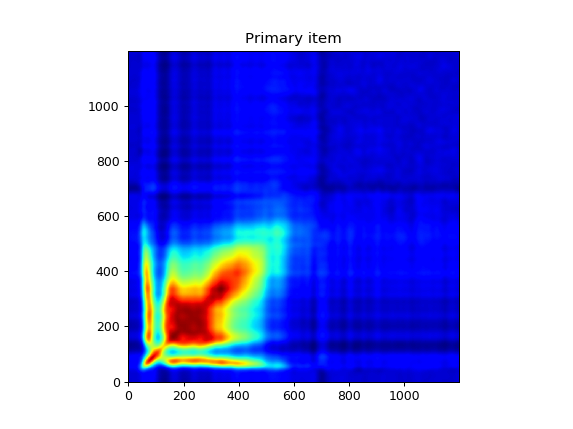

In [19]:
c1 = np.mean(cross_amp, 0)
c_transformed1 = (c1 + c1.T) / 2
filtered1 = gaussian_filter(c_transformed1, sigma=8)
plt.close()

plt.title('Primary item')
# plt.imshow(filtered1, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
plt.imshow(filtered1, cmap='jet', origin='lower')

In [4]:
with tf.device('/gpu:2'):
    n = 200
    
    @tf.function
    def expensive(x):
        a = tf.ones([10000, 10000])
        b = tf.ones([10000, 10000])
        return (a @ b)[0, 0]
    
    @tf.function
    def test():
#         tf.map_fn(expensive, tf.range(n), dtype=tf.float32, parallel_iterations=1)
        batch_size = 20
        for i in range(0, n, batch_size):
            tf.vectorized_map(expensive, tf.range(i, i+batch_size))
    
#         for i in range(n):
#             tf.print(i, end='\r')
#             expensive(0)
    
    tic = time.time()
    for i in range(n):
        print(i, end='\r')
        print(expensive(0).numpy())
    toc = time.time()
    print("Elapsed time for Python loop: " + str(toc - tic))
    
    tic = time.time()
    test()
    toc = time.time()
    print("Elapsed time for map_fn loop: " + str(toc - tic))
        
#     expensive()

Executing op __inference_expensive_2625 in device /job:localhost/replica:0/task:0/device:GPU:2
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
1

KeyboardInterrupt: 

In [3]:
20 * 10000 * 10000 * 32 / 8 / 1000 / 1000 / 1000

8.0

In [ ]:
Executing op __inference_expensive_451 in device /job:localhost/replica:0/task:0/device:GPU:2
Elapsed time for Python loop: 58.338862657547
Executing op __inference_test_550 in device /job:localhost/replica:0/task:0/device:GPU:2
Elapsed time for map_fn loop: 58.90716004371643

In [10]:
[i for i in range(0, n, 2)]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]